# Age Cross-Prediction

In [1]:
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(
    context="paper", 
    style="whitegrid", 
    font_scale=1.2,
    rc={'figure.figsize': (10, 10), 'figure.dpi': 300}
)

## Get Data

In [2]:
from common.data import get_data

X, Y, demographics, population = get_data(wisc_level=5)
ages = demographics['Age']

print(f'X: {X.shape} | Y: {len(Y.keys())} | Age: {ages.shape} | Population: {population}')

X: (380, 34716) | Y: 6 | Age: (380,) | Population: adhd


In [3]:
from common.binning import bin_by_age, ONLY_BIN_LABELS
from common.cross_prediction import get_group_cv_splits, get_group_order
from common.paths import CROSS_PRED_RESULTS
from common.results import CVResult, save_results
from common.scoring import (unimetric_scorer, 
                            custom_permutation_test_score, 
                            N_PERM, SCORING, RKF_10_10)
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

## Run for one target, one age bin

In [20]:
selected_target = "WISC_FSIQ"
y = Y[selected_target]

print(f'{selected_target}: {y.shape}')

WISC_FSIQ: (380,)


In [21]:
bins = bin_by_age(X, y, ages)
bins_cv = get_group_cv_splits(bins, RKF_10_10)

print(f'Bin 1: {bins[0][0].shape} | Bin 2: {bins[1][0].shape} | Bin 3: {bins[2][0].shape}')
print(f'bin_1_cv: {len(bins_cv[0])} | bin_2_cv: {len(bins_cv[1])} | bin_3_cv: {len(bins_cv[2])}')

Bin 1: (114, 34716) | Bin 2: (152, 34716) | Bin 3: (114, 34716)
bin_1_cv: 100 | bin_2_cv: 100 | bin_3_cv: 100


### Run permutation-test (train bin, test bin)

In [23]:
%%time
# From previous results
bin_alphas = [5000, 5000, 5000]

bin_order, bin_cv_order, bin_labels = get_group_order(bins, bins_cv, ONLY_BIN_LABELS)
results = []
perm_scores = []

for bin_alpha, bins, bins_cv, labels in zip(bin_alphas, bin_order, bin_cv_order, bin_labels):
    train_bin, test_bin_one, test_bin_two = bins[0], bins[1], bins[2]
    train_bin_cv, test_bin_one_cv, test_bin_two_cv = bins_cv[0], bins_cv[1], bins_cv[2]
    
    pipe = make_pipeline(StandardScaler(), Ridge(alpha=bin_alpha))
    rs, perms, ps = custom_permutation_test_score(
        pipe, train_bin, test_bin_one, test_bin_two, 
        train_bin_cv, test_bin_one_cv, test_bin_two_cv, N_PERM, unimetric_scorer)
    
    train_group = labels[0]
    for r, p, test_group in zip(rs, ps, labels):
        results.append(
            CVResult('ridge', selected_target, train_group, test_group, r, p, 'adhd', N_PERM)
        )
    perm_scores.append(perms)
    print(f'Train Group: {train_group}')

results_df = pd.DataFrame([r.to_dict() for r in results])
display(results_df.round(4))
# filename = f'ridge_pts_age_cross_prediction.csv'
# results_fp = save_results(results_df, filename, CROSS_PRED_RESULTS)
# print('Results saved to:', results_fp)

Train Group: Bin 1
Train Group: Bin 2
Train Group: Bin 3


,Model,Target,Train,Test,Score,P-value,Population,Num Permutations
0,ridge,WISC_FSIQ,Bin 1,Bin 1,0.2219,0.0279,adhd,500
1,ridge,WISC_FSIQ,Bin 1,Bin 2,0.3274,0.0020,adhd,500
2,ridge,WISC_FSIQ,Bin 1,Bin 3,0.2355,0.0040,adhd,500
3,ridge,WISC_FSIQ,Bin 2,Bin 2,0.3770,0.0040,adhd,500
4,ridge,WISC_FSIQ,Bin 2,Bin 3,0.2576,0.0060,adhd,500
5,ridge,WISC_FSIQ,Bin 2,Bin 1,0.3420,0.0020,adhd,500
6,ridge,WISC_FSIQ,Bin 3,Bin 3,0.0936,0.2475,adhd,500
7,ridge,WISC_FSIQ,Bin 3,Bin 1,0.2488,0.0040,adhd,500
8,ridge,WISC_FSIQ,Bin 3,Bin 2,0.2990,0.0020,adhd,500


CPU times: user 1d 1h 56min 3s, sys: 29min 20s, total: 1d 2h 25min 23s
Wall time: 2h 38min 32s


### Visualize permutation results

In [28]:
perms = np.array(perm_scores).reshape(9, N_PERM)
perms = pd.DataFrame(perms)

selected_results = results_df['Train'] == results_df['Test']

true_score = results_df[selected_results]
perm_score = perms[selected_results]
perm_score['Bin'] = [1, 2, 3]
perm_score = perm_score.melt(id_vars='Bin', var_name='Perm_num', value_name='r')

display(true_score)
display(perm_score)

/home/bpho/.conda/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Model,Target,Train,Test,Score,P-value,Population,Num Permutations
0,ridge,WISC_FSIQ,Bin 1,Bin 1,0.221912,0.027944,adhd,500
3,ridge,WISC_FSIQ,Bin 2,Bin 2,0.377022,0.003992,adhd,500
6,ridge,WISC_FSIQ,Bin 3,Bin 3,0.093603,0.247505,adhd,500


,Bin,Perm_num,r
0,1,0,-0.158105
1,2,0,0.075939
2,3,0,0.126514
3,1,1,-0.037011
4,2,1,-0.137575
...,...,...,...
1495,2,498,0.061932
1496,3,498,0.004786
1497,1,499,0.115847
1498,2,499,0.033994


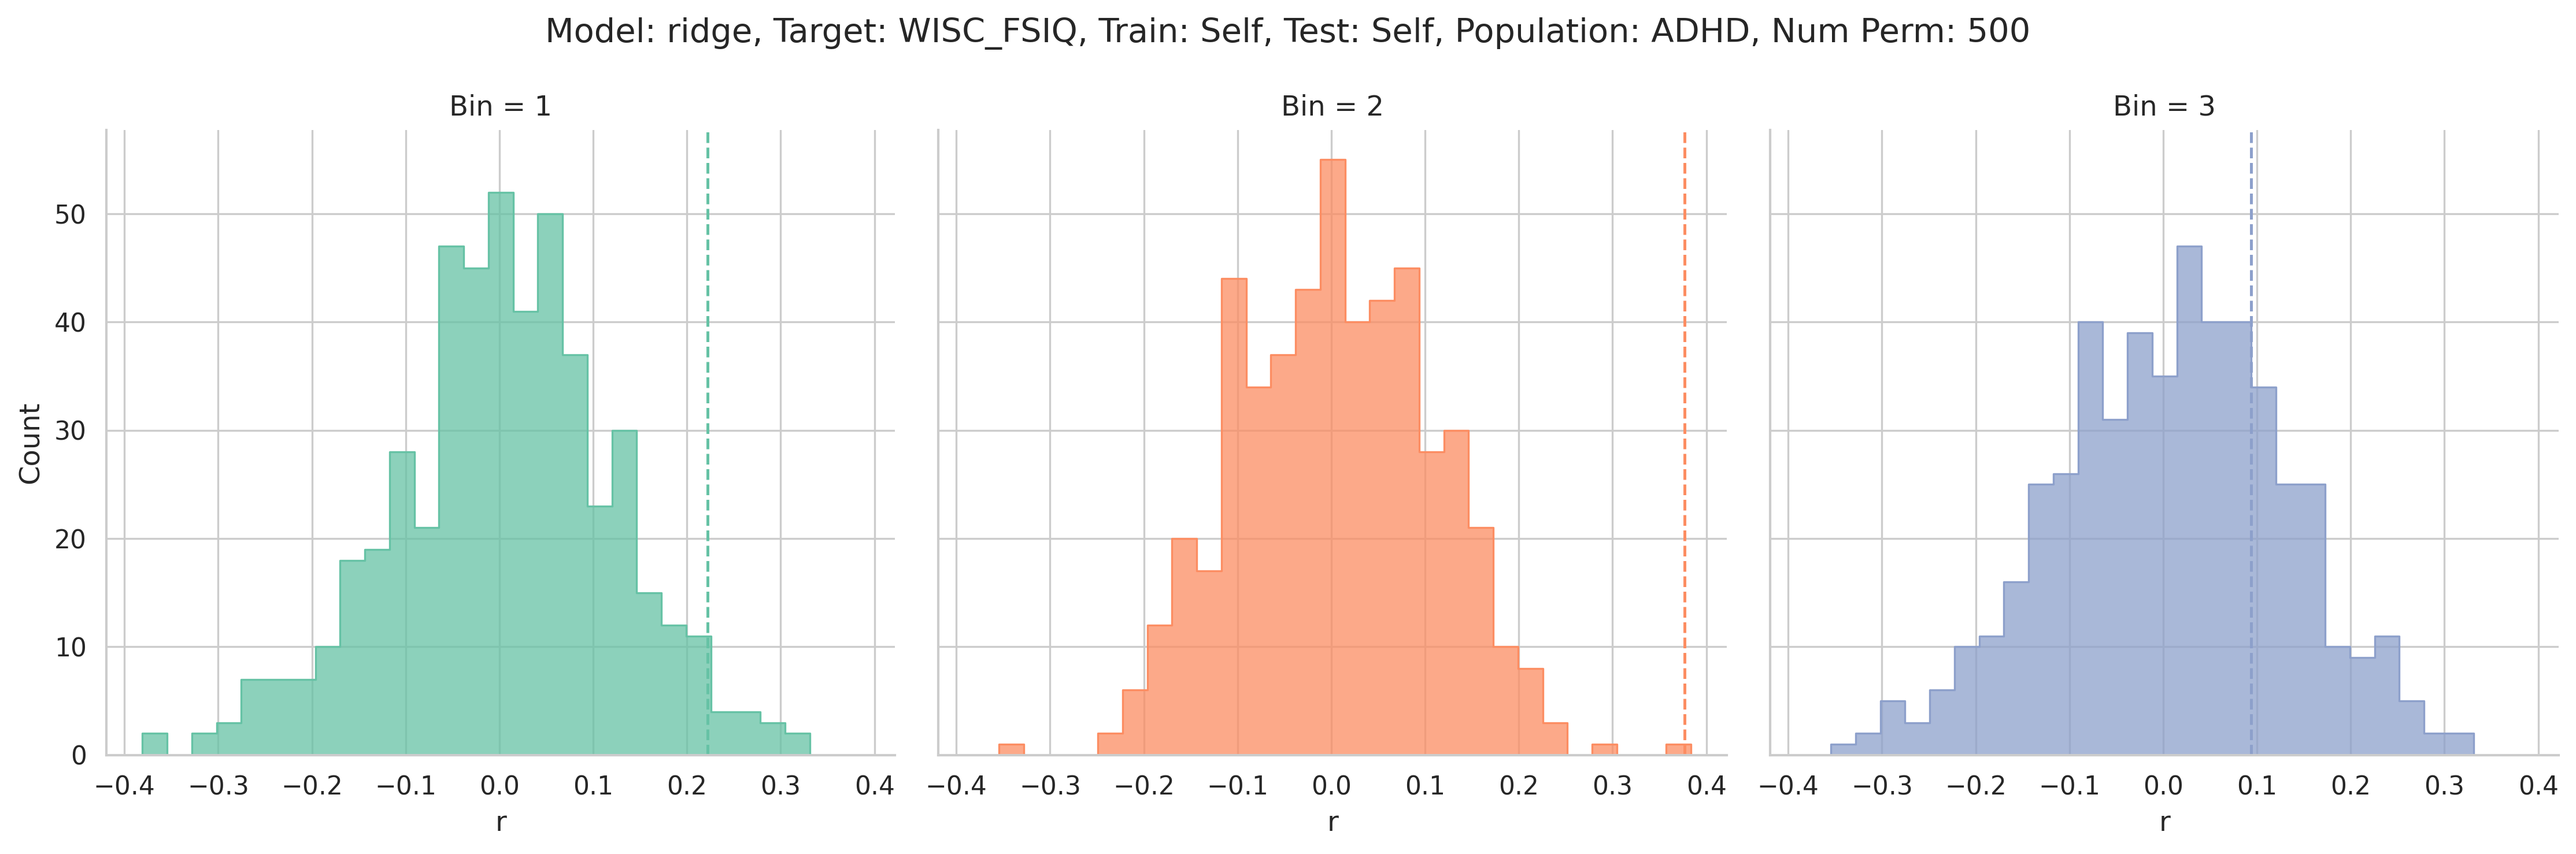

In [29]:
# Discrete variant
g = sns.displot(perm_score, x="r", hue="Bin", palette="Set2", element="step", col='Bin', legend=False)
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle(f'Model: ridge, Target: {selected_target}, Train: Self, Test: Self, Population: ADHD, Num Perm: {N_PERM}')
for col_val, ax in g.axes_dict.items():
    bin_idx = col_val - 1
    ax.axvline(true_score['Score'].iloc[bin_idx], ls="--", color=sns.color_palette("Set2")[bin_idx])

# Continuous variant
# g = sns.displot(perm_score, x="r", hue="Bin", palette="Set2", kind="kde", fill=True, col='Bin')
# for col_val, ax in g.axes_dict.items():
#     bin_idx = col_val - 1
#     ax.axvline(true_score['Score'].iloc[bin_idx], ls="--", color=sns.color_palette("Set2")[bin_idx])

<AxesSubplot:xlabel='Test', ylabel='Score'>

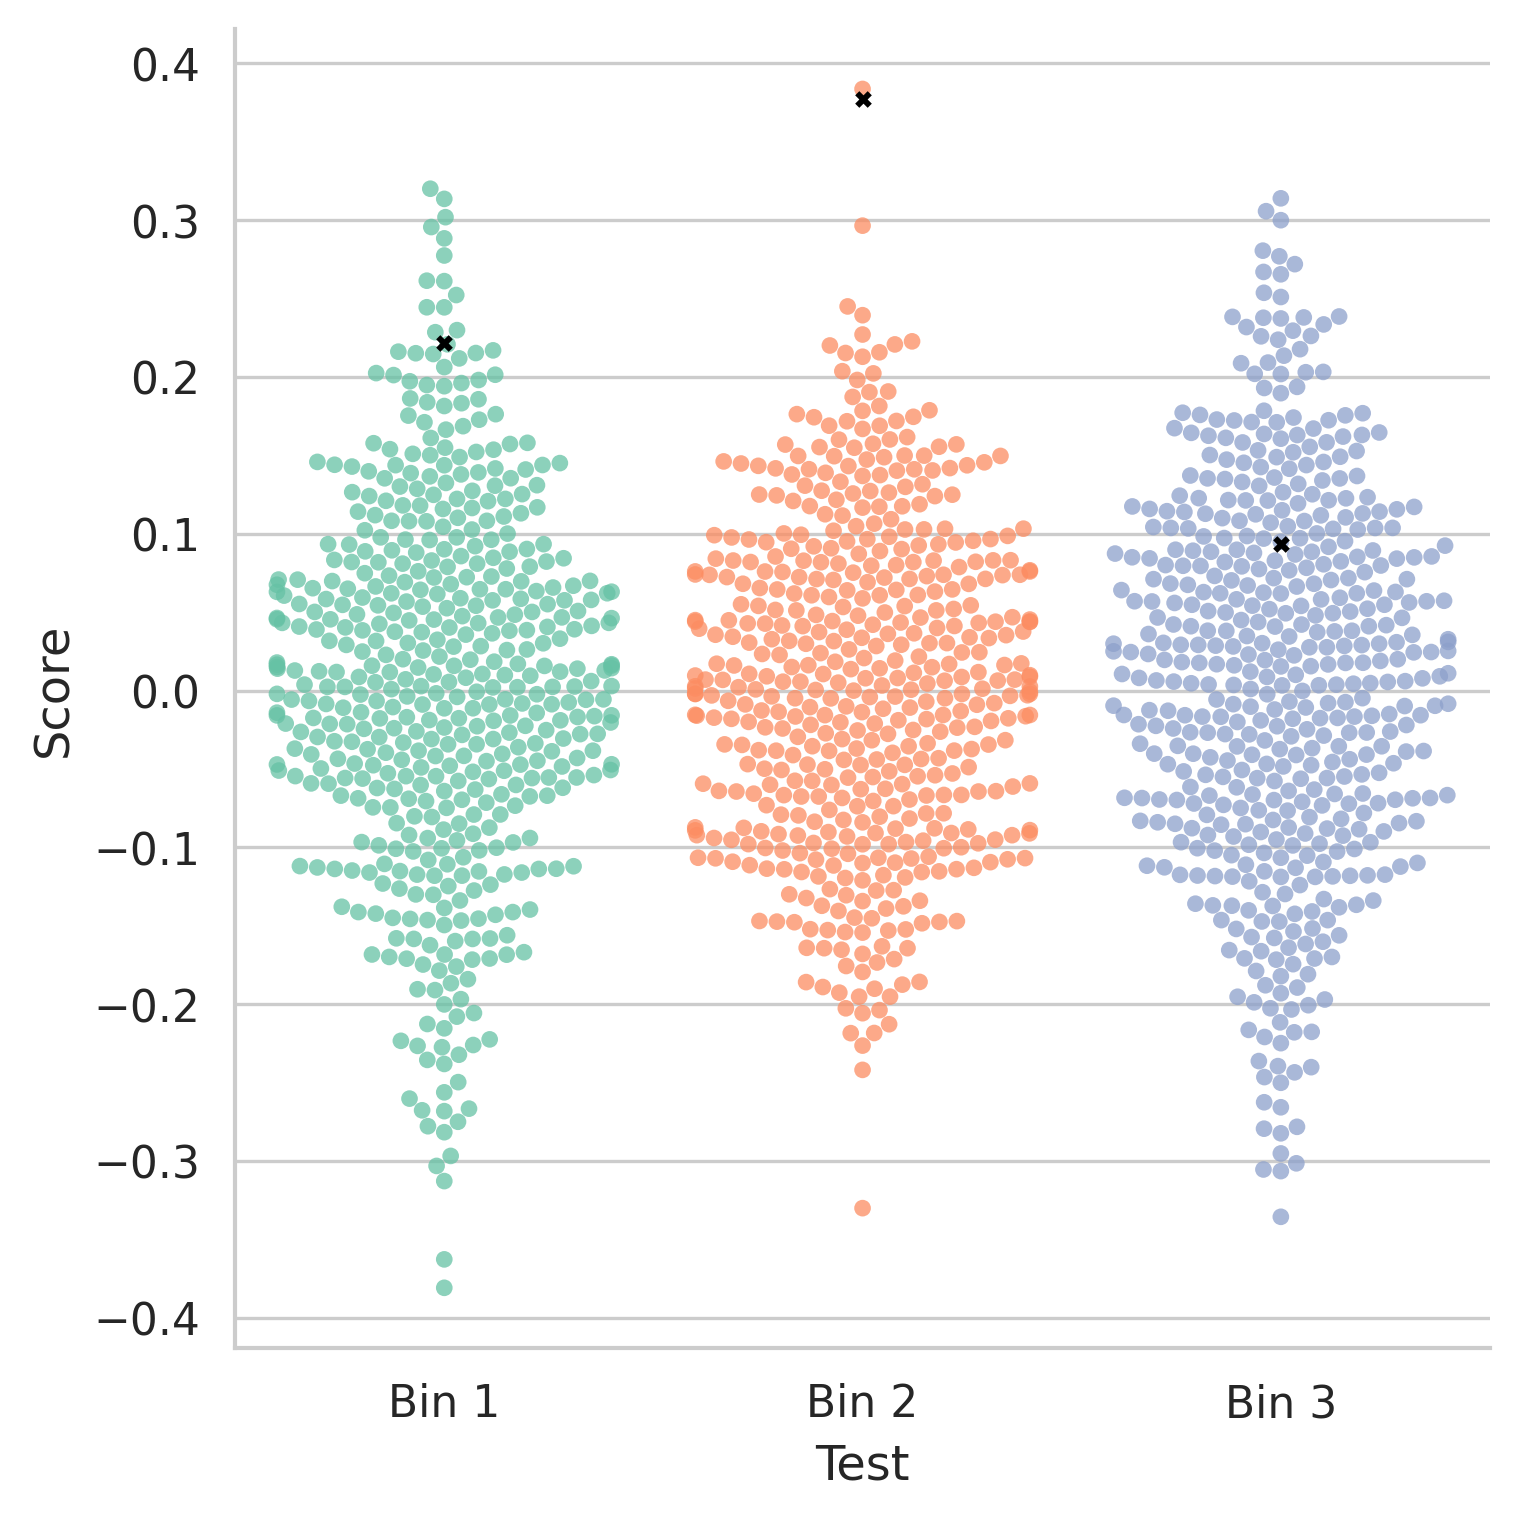

In [37]:
g = sns.catplot(x='Bin', y='r', data=perm_score, kind="swarm", palette="Set2", alpha=.75, s=4)
sns.swarmplot(x='Test', y='Score', data=true_score, ax=g.ax, color='black', alpha=1, marker='X', s=4)